In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [9]:
df = pd.read_csv('df_short_1.csv')

In [36]:
df_train_val, df_test = train_test_split(df, test_size=0.1, shuffle=True)

In [37]:
df_test

,Prop Type,S/A,Price,Yr Blt,TypeDwel,# of Kitchens,# Rms,Age,Floor Area -Grand Total,Area,...,Lot Sz (Sq.Ft.),View,Fireplaces,Parking Places - Total,No. Floor Levels,Dist to School/School Bus changed,Distance to Pub/Rapid Tr changed,Zoning changed,Realtor remarks sentiment classified,Public remarks sentiment classified
34635,Residential Detached,Burke Mountain,1650000,202.0,HOUSE,2.0,10.0,1818.0,3916.0,Coquitlam,...,0.00,Yes,1.0,4.0,3.0,Close,Close,RS,positive,positive
28770,Residential Attached,Coquitlam West,1386000,2013.0,OTHER,1.0,11.0,8.0,1737.0,Coquitlam,...,4031.00,No,1.0,3.0,3.0,Not Close,Not Close,RT,positive,positive
25677,Residential Detached,Woodwards,1240000,1976.0,HOUSE,1.0,9.0,44.0,1885.0,Richmond,...,5554.00,No,1.0,4.0,2.0,Close,Close,RS,positive,positive
36757,Residential Detached,Fraserview VE,1835000,1988.0,HOUSE,2.0,18.0,33.0,3495.0,Vancouver East,...,7604.76,No,2.0,4.0,2.0,Close,Close,other,positive,positive
49143,Residential Attached,College Park PM,577500,2007.0,APTU,1.0,8.0,13.0,1129.0,Port Moody,...,0.00,Yes,1.0,2.0,1.0,Not Close,Not Close,RA,negative,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24085,Residential Attached,Knight,1165000,2009.0,TWNHS,1.0,11.0,12.0,1236.0,Vancouver East,...,0.00,No,0.0,1.0,2.0,Close,Close,RT,negative,positive
29755,Residential Attached,Downtown NW,494350,2017.0,APTU,1.0,4.0,4.0,575.0,New Westminster,...,0.00,No,0.0,1.0,1.0,Close,Close,CD,positive,positive
54457,Residential Attached,Uptown NW,436000,1982.0,APTU,1.0,8.0,39.0,840.0,New Westminster,...,0.00,No,0.0,1.0,1.0,Close,Close,RA,negative,positive
467,Residential Attached,Simon Fraser Univer.,449000,2017.0,APTU,1.0,3.0,3.0,676.0,Burnaby North,...,0.00,Yes,0.0,1.0,2.0,Close,Close,CD,positive,positive


In [38]:
y = df_train_val.Price
X = df_train_val.drop(['Price'], axis=1)

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
categorical_cols = [cname for cname in X_train_full.columns if 
                        X_train_full[cname].dtype == "object"]

numerical_cols = [cname for cname in X_train_full.columns if df[cname].dtype in ['int64', 'float64','int32']]

my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [39]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label', OneHotEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [40]:
model = ExtraTreesRegressor(n_jobs=-1)

In [41]:
from sklearn.metrics import mean_absolute_error, r2_score

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)


MAE: 140262.86017988177


In [42]:
comparison = y_valid.to_frame()

In [43]:
comparison['Prediction'] = preds.tolist()

In [44]:
comparison['error_percentage'] = (comparison.Prediction - comparison.Price)/comparison.Price * 100

(array([5.93e+02, 8.93e+03, 2.39e+02, 3.50e+01, 1.00e+01, 2.00e+00,
        0.00e+00, 0.00e+00, 2.00e+00, 1.00e+00]),
 array([-61.36652597, -14.63846526,  32.08959545,  78.81765616,
        125.54571688, 172.27377759, 219.0018383 , 265.72989901,
        312.45795972, 359.18602043, 405.91408115]),
 <BarContainer object of 10 artists>)

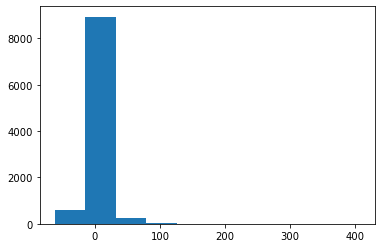

In [45]:
plt.hist(comparison['error_percentage'])

In [46]:
comparison.error_percentage.abs().mean()

9.18956416663701

In [47]:
comparison.to_csv('comparison.csv')

In [48]:
df_train_val.to_csv('df_short_train_val.csv', index=False)

In [49]:
df_test.to_csv('df_short_test.csv', index=False)

In [50]:
import pickle

pickle.dump(my_pipeline, open('data_3_model_2','wb'))
